# SgrA* Comparison: Qmetric
---
This notebook compares Q-metric[1] for synthetic Noisy [2,3] generated movies to SgrA* data. 

**Note the 'dev' branch of ehtim is needed.**

[1] F. Roelofs, M. D. Johnson, H. Shiokawa, S. Doeleman and H. Falacke, Quantifying Intrinsic Variability of Sagittarius A* Using Close Phase Measurements of The Event Horizon Telescope: https://arxiv.org/pdf/1708.01056.pdf

[2] https://github.com/AFD-Illinois/noisy

[3] https://github.com/aviadlevis/pynoisy



In [1]:
import numpy as np
from pynoisy import qmetric_functions as qm
import matplotlib.pyplot as plt
import glob
import ehtim as eh
import os
import pandas as pd
import matplotlib
import json
from IPython.display import display, HTML
import paramiko

eht_home = '/home/aviad/Code/eht-imaging/'

Welcome to eht-imaging! v  1.1.1


In [60]:
"""
Function definitions
"""
def file_list_from_df(df):
    file_list = []
    for index in df.index:
        file = '{}'.format(index[0]) + \
        ''.join(['*{}{}'.format(name, value) for name, value in zip(df.index.names[1:], index[1:])]) + '*'
        file_list.append(file)
    return file_list

def zero_baseline_std(obs):
    tmp = obs.unpack(['u', 'v', 'amp'], debias=True)
    amp, u, v = tmp['amp'], tmp['u'], tmp['v']
    return np.std(amp[np.sqrt(u**2 + v**2) < 1e8])

def compute_qmetric_df(uvfile, date=3599, tavg=120, bintime=0, segtime=0, diftime=0, detrend_deg=3):
    """Compute a qmetric dataframe
    
    Q-metric detrending parameters
        tavg: Averaging time in seconds
        bintime: bin time for unevenly sampled data
        segtime: split into segments of segtime before detrending and calculating Q
        diftime: differencing time
        detrend_deg: degree of detrending polynomial
    """
    obs = eh.obsdata.load_uvfits(uvfile)
    
    # Average
    obs = obs.avg_coherent(tavg)
    
    # Calculate closure phases
    obs_cphases = obs.c_phases()
    
    # List nontrivial triangles
    triangle_list = []
    for i in range(len(obs_cphases)):
        triangle = [obs_cphases['t1'][i], obs_cphases['t2'][i], obs_cphases['t3'][i]]

        if 'AA' in triangle and 'AP' in triangle:
            continue
        if 'JC' in triangle and 'SM' in triangle:
            continue

        if triangle not in triangle_list:
            triangle_list.append(triangle)
            
    # Calculate Q for measured closure phases
    zbl_std = zero_baseline_std(obs)
    qmetric = {'triangle': [], 'date': [date]*len(triangle_list), 'q': [], 'dq': [], 'zbl_std': [zbl_std]*len(triangle_list)}
    for triangle in triangle_list:
        this_cphases = obs.cphase_tri(triangle[0], triangle[1], triangle[2])
        time = this_cphases['time']
        cp = this_cphases['cphase']
        err = this_cphases['sigmacp']
        q, dq = qm.qmetric(
            time, cp, err, bintime=bintime, segtime=segtime, diftime=diftime, detrend_deg=detrend_deg
        )
        qmetric['triangle'].append('{}-{}-{}'.format(*triangle))
        qmetric['q'].append(q)
        qmetric['dq'].append(dq)

    return pd.DataFrame(qmetric)

## SgrA Q-metric

In [61]:
run_name = 'SgrA'
band = 'lo'
cal = 'LMTcal'
dates = [3597, 3598, 3599, 3600, 3601]

uvfolder = os.path.join(eht_home, 'SgrA/data/calibrated_data_oct2019/')
file_format = 'frankenstein_{{date}}_{}_SGRA_polcal_netcal_{}_10s.uvfits'.format(band, cal)

### Compute Qmetric

In [62]:
%%capture

# Define Q-metric parameters
params = {'tavg': 120, 'bintime': 0, 'segtime': 0, 'diftime': 0, 'detrend_deg': 3}

qmetric_df = pd.concat(
    [compute_qmetric_df(uvfolder + file_format.format(date=date), date, **params) for date in dates]
)

output_path = os.path.join(
    uvfolder, 
    'qmetric_sgra_{}_{}'.format(band, cal) + 
    ''.join(['_{}{}'.format(key, value) for key, value in params.items()]) + 
    '.csv'
)
qmetric_df.to_csv(output_path)

### Load precomputed CSV

In [89]:
sgra_df = pd.read_csv(
    os.path.join(uvfolder, 'qmetric_sgra_lo_LMTcal_tavg120_bintime0_segtime0_diftime0_detrend_deg3.csv')
)
median_sgra = sgra_df.groupby('triangle').q.median()
median_sgra_df = pd.DataFrame(median_sgra)

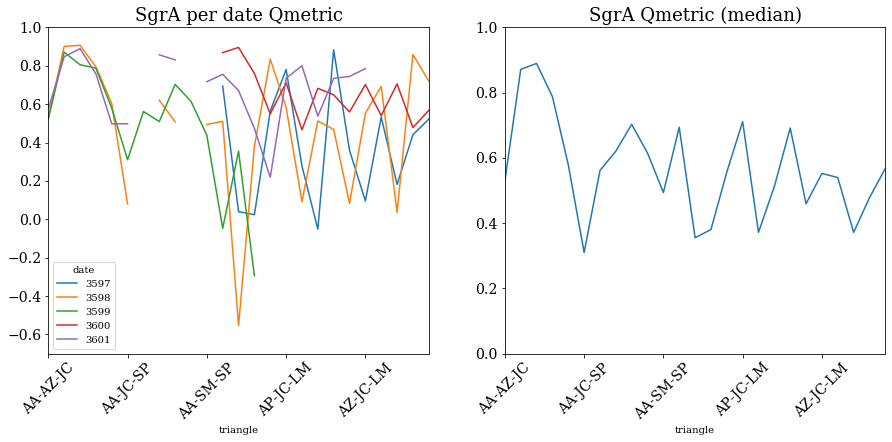

In [90]:
%matplotlib inline
fig, axes = plt.subplots(1,2, figsize=(15,6))
sgra_q_df = sgra_df.groupby(['triangle', 'date'])['q','dq'].mean().unstack()
sgra_q_df.plot(y='q', ax=axes[0])
plt.sca(axes[0])
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title('SgrA per date Qmetric', fontsize=18);
plt.ylim([-0.7, 1]);

median_sgra.plot(ax=axes[1])
plt.sca(axes[1])
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title('SgrA Qmetric (median)', fontsize=18);
plt.ylim([0, 1]);

## Enevlope Q-metric Comparison

In [68]:
noisy_df = pd.read_csv(
    os.path.join(eht_home, 'SgrA/synthetic_data_SGRA_3599_lo/allmodel_v2.5/17-Mar-2020-18:04:13/' + 
                 'qmetric_3599_tavg120.0_bintime0.0_segtime0.0_diftime0.0_detrend_deg3.csv')
)
display(noisy_df.head())

,Unnamed: 0,triangle,date,q,dq,zbl_std,envelope,angle,radius,rotation,...,dur,amp,tau,lam,tensor_ratio,day,lpolmag,lpolcorr,cpolmag,cpolcorr
0,0,AA-PV-SP,3599,0.724614,0.049864,0.282864,dbsrc_fiducial,30.0,19.0,cw,...,0.3,0.4,1.0,0.5,0.1,3599,0.3,10.0,0.1,5.0
1,1,AA-LM-PV,3599,0.384311,0.185637,0.282864,dbsrc_fiducial,30.0,19.0,cw,...,0.3,0.4,1.0,0.5,0.1,3599,0.3,10.0,0.1,5.0
2,2,AA-LM-SP,3599,0.697650,0.042974,0.282864,dbsrc_fiducial,30.0,19.0,cw,...,0.3,0.4,1.0,0.5,0.1,3599,0.3,10.0,0.1,5.0
3,3,AA-AZ-LM,3599,0.868791,0.022502,0.282864,dbsrc_fiducial,30.0,19.0,cw,...,0.3,0.4,1.0,0.5,0.1,3599,0.3,10.0,0.1,5.0
4,4,AA-AZ-SP,3599,0.835270,0.023654,0.282864,dbsrc_fiducial,30.0,19.0,cw,...,0.3,0.4,1.0,0.5,0.1,3599,0.3,10.0,0.1,5.0


In [162]:
"""
The top Q-metric per envelope
"""
mean_noisy_df = noisy_df.pivot_table(
    index=['envelope', 'angle', 'eps', 'dur', 'amp'], values=['q', 'dq']
)
print('Top mean(Q) (over triangles) per envelope')
topq = mean_noisy_df['q'].groupby(level=0, group_keys=False)
display(topq.nlargest(1))

Top mean(Q) (over triangles) per envelope


envelope                  angle  eps  dur  amp
crescent_fiducial1        30.0   0.3  0.4  0.4    0.902892
crescent_fiducial2        60.0   0.4  0.3  0.4    0.946701
dbsrc_fiducial            60.0   0.4  0.4  0.4    0.907568
elliptical_disk_fiducial  30.0   0.3  0.4  0.4    0.928103
ring_model_fiducial2      60.0   0.4  0.3  0.4    0.937792
simple_disk               60.0   0.4  0.4  0.4    0.953061
Name: q, dtype: float64

In [285]:
"""
The closest to SgrA (on average) Q-metric and zero-baseline std per envelope
"""
median_sgra_df = pd.DataFrame(sgra_df.groupby('triangle')['q', 'zbl_std'].median())
df = noisy_df.pivot_table(index=['envelope', 'angle', 'eps', 'dur', 'amp', 'triangle'], values=['q', 'zbl_std'])

whitened_noisy = (df - df.groupby('triangle').mean()) / df.groupby('triangle').std()
whitened_sgra = (median_sgra_df - df.groupby('triangle').mean()) / df.groupby('triangle').std()

diff_df = (whitened_noisy - whitened_sgra).abs()
diff_df = pd.DataFrame(np.sqrt(diff_df.q**2 + diff_df.zbl_std**2), columns=['sgr similarity'])
diff_df = diff_df.groupby(['envelope', 'angle', 'eps', 'dur', 'amp']).mean()


top_sgr = diff_df['sgr similarity'].groupby(level=0, group_keys=False).nsmallest(1).sort_values()
display(top_sgr)

envelope                  angle  eps  dur   amp
crescent_fiducial1        60.0   0.4  0.30  0.3    0.555521
elliptical_disk_fiducial  60.0   0.2  0.10  0.4    0.557969
simple_disk               60.0   0.3  0.20  0.3    0.581260
ring_model_fiducial2      60.0   0.1  0.20  0.4    0.616964
crescent_fiducial2        60.0   0.4  0.40  0.3    0.626086
dbsrc_fiducial            30.0   0.3  0.05  0.3    0.642765
Name: sgr similarity, dtype: float64

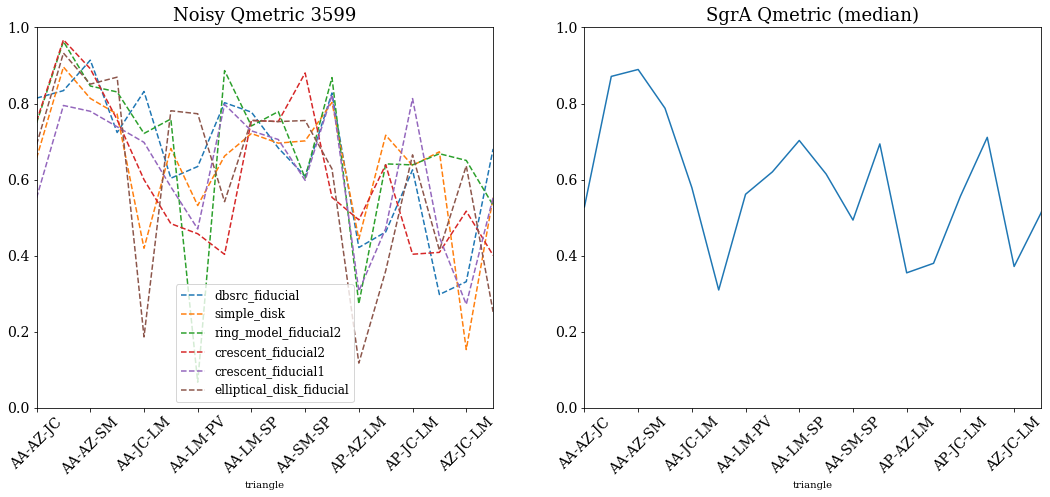

In [286]:
df = pd.DataFrame(noisy_df.set_index(['envelope', 'angle', 'eps', 'dur', 'amp']))
top_noisy = df.loc[top_sgr.index].reset_index().set_index('triangle')
top_noisy.sort_index(inplace=True)

%matplotlib inline
fig, axes = plt.subplots(1,2, figsize=(18,7))
top_noisy.groupby('envelope').q.plot(ax=axes[0], style='--')
plt.sca(axes[0])
plt.title('Noisy Qmetric 3599', fontsize=18);
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0, 1]);
plt.legend(noisy_df.envelope.unique(), fontsize=12)

median_sgra.plot(ax=axes[1])
plt.sca(axes[1])
plt.xticks(ticks=axes[0].get_xticks(), labels=axes[0].get_xticklabels(), rotation=45, fontsize=14)
plt.xlim(axes[0].get_xlim())
plt.yticks(fontsize=14)
plt.title('SgrA Qmetric (median)', fontsize=18);
plt.ylim([0, 1]);